In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 4.1+
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import torchvision

% matplotlib inline

UsageError: Line magic function `%` not found.


# Convolutional β-Variational Autoencoder

In [7]:
CUDA = True

ZDIMS = 20
BETA = 5
LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 100

In [11]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

## Get Data

In [92]:
# Directories
image_dir_base = 'C:\\git\\PyTorch_Pill_Fingerprint\\data_with_many_rotations'
image_dir_training = image_dir_base + '\\train'
image_dir_validation = image_dir_base + '/validate'
image_dir_testing = image_dir_base + '/test'
image_dir_samples = image_dir_testing
print(image_dir_training)

tfrms = transforms.Compose(
        [transforms.Resize((222,150)),
         transforms.ToTensor()
        ])

tfrms = transforms.Compose(
        [transforms.Resize((28,28)),
         transforms.ToTensor()
        ])

train_dataset = torchvision.datasets.ImageFolder(
    root=image_dir_training,
    transform=tfrms #torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
    root=image_dir_training,
    transform=tfrms #torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=0,
    shuffle=True
)

#for batch_idx, (data, target) in enumerate(load_dataset()):
    #train network

C:\git\PyTorch_Pill_Fingerprint\data_with_rotations\train


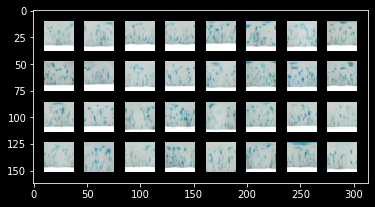

In [93]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

#x = next(iter(train_loader))
images,labels = iter(train_loader).next()
#x = train_loader.batch_sampler.sampler.num_samples
#print(labels)
#torchvision.utils.save_image(x.float(),'C:\\git\\test.jpg')

x = torchvision.utils.make_grid(images, nrow=8, padding=10, scale_each=True)
show(x)

In [94]:
print('hi')

hi


## Architecture

Because I plan on using this for dimension reduction, I based the architecture loosely on Convolutional Variational Autoencoder featured in the influential World Models research paper. It has been modified with a β coefficient for disentangling the latent features/vectors.
 - https://worldmodels.github.io/
 - https://github.com/hardmaru/WorldModelsExperiments
 - https://github.com/hardmaru/WorldModelsExperiments/blob/master/carracing/vae/vae.py

In [95]:
NC = 3    # channels
NEF = 64  # init encoding filters
NDF = 64  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        
        self.encoder = nn.Sequential(
            
            # input is (NC) x 28 x 28 (MNIST)
            nn.Conv2d(in_channels = NC, out_channels = NEF, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(inplace = True),

            # conv layer 2
            nn.Conv2d(in_channels = NEF, out_channels = NEF * 2, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(NEF * 2),
            nn.ReLU(inplace = True),

            # conv layer 3
            nn.Conv2d(in_channels = NEF * 2, out_channels = NEF * 4, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(NEF * 4),
            nn.ReLU(inplace = True),

            # conv layer 4
            nn.Conv2d(in_channels = NEF * 4, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1),
            #nn.BatchNorm2d(1024), # OPTIONAL
            nn.ReLU(inplace = True)

        )

        self.decoder = nn.Sequential(

            # input is Z (post-fc)
            nn.ConvTranspose2d(in_channels = 1024, out_channels = NDF * 8, kernel_size = 4, stride = 1, padding = 0),
            nn.BatchNorm2d(NDF * 8),
            nn.ReLU(inplace = True),

            # deconv layer 2
            nn.ConvTranspose2d(in_channels = NDF * 8, out_channels = NDF * 4, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(NDF * 4),
            nn.ReLU(inplace = True),

            # deconv layer 3
            nn.ConvTranspose2d(in_channels = NDF * 4, out_channels = NDF * 2, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(NDF * 2),
            nn.ReLU(inplace = True),

            # deconv layer 4
            nn.ConvTranspose2d(in_channels = NDF * 2, out_channels = NC, kernel_size = 4, stride = 2, padding = 1),
            nn.Sigmoid()

        )
        
        # conv fc
        self.fc11 = nn.Linear(1024, self.zdims) # mu
        self.fc12 = nn.Linear(1024, self.zdims) # logvar
        
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, 1024)
    
    
    def encode(self, x):
        conv = self.encoder(x)
        conv = conv.view(-1, 1024)
        mu = self.fc11(conv)
        logvar = self.fc12(conv)
        return mu, logvar
    
    def decode(self, z):
        deconv_input = F.relu(self.fc2(z))
        deconv_input = deconv_input.view(-1, 1024, 1, 1) # world models: [-1, 1, 1, 1024]
        recon_x = self.decoder(deconv_input)
        return recon_x
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

## Init Model

In [96]:
model = VAE(zdims = ZDIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

## Train Ops

In [105]:
def loss_function(recon_x, x, mu, logvar, beta = 1):
    '''Use a beta value of 1 for a vanilla VAE'''
    
    # loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction = 'sum')
    
    # KL Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + (beta * KLD)

def train(epoch, beta = 1):
    
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, Z = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset)
    ))
    
def test(epoch):
    
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, Z = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]]) #recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
    
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Train

In [106]:
# train model
for epoch in range(1, EPOCHS + 1):
    train(epoch, beta = BETA) # note: beta not currently considered in validation error
    test(epoch)

C:\Users\stborg\AppData\Local\Continuum\anaconda3\envs\fastai_everything\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Using a target size (torch.Size([96, 784])) that is different to the input size (torch.Size([32, 3, 28, 28])) is deprecated. Please ensure they have the same size.
  """
Train Epoch: 1 [0/722 (0%)]	Loss: 1163.309937
C:\Users\stborg\AppData\Local\Continuum\anaconda3\envs\fastai_everything\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Using a target size (torch.Size([54, 784])) that is different to the input size (torch.Size([18, 3, 28, 28])) is deprecated. Please ensure they have the same size.
  """
====> Epoch: 1 Average loss: 1181.2426
C:\Users\stborg\AppData\Local\Continuum\anaconda3\envs\fastai_everything\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Using a target size (torch.Size([48, 784])) that is different to the input size (torch.Size([16, 3, 28, 28])) is deprecated. Please ensure they have the same size.
  """
C:\Users\stborg\Ap

In [108]:
# sample from latent space
with torch.no_grad():
    sample = torch.randn(64, ZDIMS).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample, 'results/sample_' + str(epoch) + '.png')
    #save_image(sample.view(64, 1, 28, 28), 'results/sample_' + str(epoch) + '.png')

## Initial Results

*NOTE: because the input data (MNIST vs World Models) is very different, most of the layer hyperparams had to be adjusted. Otherwise, the biggest difference is that Batch Normalization, which showed a lower training and validation error, is used.

 - **Modified World Models**
     - val loss = 78.1520 (min: 77.5991)
     - zdims = 20
     - beta = 1
     - batch size = 64
     - batchnorm = False
 - **Modified World Models + BatchNorm (not on last encoding layer)**
     - val loss = 76.4446 (min: 76.0836)
     - zdims = 20
     - beta = 1
     - batch size = 64
     - batchnorm = True
 - **Modified World Models + BatchNorm (including last encoding layer)**
     - val loss = 76.3589 (min: 76.1684)
     - zdims = 20
     - beta = 1
     - batch size = 64
     - batchnorm = True
 - **Modified World Models + BatchNorm (not on last encoding layer) w/ beta**
     - val loss = 85.2611 (min: 85.2245)
     - zdims = 20
     - beta = 5
     - batch size = 64
     - batchnorm = True

# Next Steps

Although the results are good, it is unclear from the validation error alone whether or not the latent vectors are being disentangled in a way that features can be extracted. Next I will use the latent vectors at various beta levels to test the classification effectiveness/accuracy. Additionally, while the VAE generalizes well, it is not effective in situations when the reconstructed image's quality (clarity / bluriness) cannot be sacrificed -- for this reason, I will also test the performance of the MMD-VAE (InfoVAE).

https://arxiv.org/pdf/1706.02262.pdf